In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
from pathlib import Path
from time import time

import arviz as az
import janitor
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm
import seaborn as sns

In [3]:
from src.analysis import pymc3_analysis as pmanal
from src.data_processing import achilles as achelp
from src.data_processing import common as dphelp
from src.data_processing import vectors as vhelp
from src.globals import get_pymc3_constants
from src.io.data_io import DataFile, data_path
from src.loggers import logger
from src.plot.color_pal import SeabornColor
from src.plot.plotnine_helpers import set_gg_theme

In [4]:
notebook_tic = time()

warnings.simplefilter(action="ignore", category=UserWarning)
set_gg_theme()
%config InlineBackend.figure_format = "retina"
PYMC3 = get_pymc3_constants()
RANDOM_SEED = 847
np.random.seed(RANDOM_SEED)

In [5]:
crc_subsample_df = pd.read_csv(data_path(DataFile.DEPMAP_CRC_SUBSAMPLE))
crc_subsample_df.head()

,sgrna,replicate_id,lfc,p_dna_batch,genome_alignment,hugo_symbol,screen,multiple_hits_on_gene,sgrna_target_chr,sgrna_target_pos,...,num_mutations,any_deleterious,any_tcga_hotspot,any_cosmic_hotspot,is_mutated,copy_number,lineage,primary_or_metastasis,is_male,age
0,ACGCCACTGACACTCAAGG,LS513_c903R1,0.583209,ERS717283.plasmid,chr1_27006713_-,TENT5B,sanger,True,1,27006713,...,0,NaN,NaN,NaN,False,0.961139,colorectal,primary,True,63.0
1,AGCTGAGCGCAGGGACCGGG,LS513-311Cas9_RepA_p6_batch2,-0.020788,2,chr1_27012633_-,TENT5B,broad,True,1,27012633,...,0,NaN,NaN,NaN,False,0.961139,colorectal,primary,True,63.0
2,CTACTAGACTTCCTGCCGGC,LS513-311Cas9_RepA_p6_batch2,-0.666070,2,chr1_27006754_-,TENT5B,broad,True,1,27006754,...,0,NaN,NaN,NaN,False,0.961139,colorectal,primary,True,63.0
3,AAACTTGCTGACGTGCCTGG,LS513-311Cas9_RepA_p6_batch2,-0.130231,2,chr4_52628042_-,USP46,broad,True,4,52628042,...,0,NaN,NaN,NaN,False,0.952543,colorectal,primary,True,63.0
4,AACAACTAACTTTGTACAT,LS513_c903R1,0.226828,ERS717283.plasmid,chr8_81679130_-,IMPA1,sanger,True,8,81679130,...,0,NaN,NaN,NaN,False,0.957015,colorectal,primary,True,63.0


In [6]:
crc_subsample_df.columns.to_list()

['sgrna',
 'replicate_id',
 'lfc',
 'p_dna_batch',
 'genome_alignment',
 'hugo_symbol',
 'screen',
 'multiple_hits_on_gene',
 'sgrna_target_chr',
 'sgrna_target_pos',
 'depmap_id',
 'counts_final',
 'counts_initial',
 'rna_expr',
 'num_mutations',
 'any_deleterious',
 'any_tcga_hotspot',
 'any_cosmic_hotspot',
 'is_mutated',
 'copy_number',
 'lineage',
 'primary_or_metastasis',
 'is_male',
 'age']

In [7]:
n_genes = crc_subsample_df.hugo_symbol.nunique()
print(f"Number of genes in data: {n_genes}")

n_celllines = crc_subsample_df.depmap_id.nunique()
print(f"Number of cell lines in data: {n_celllines}")

Number of genes in data: 114
Number of cell lines in data: 10


In [8]:
screen_total_reads = pd.read_csv(data_path(DataFile.SCREEN_READ_COUNT_TOTALS))
pdna_total_reads = pd.read_csv(data_path(DataFile.PDNA_READ_COUNT_TOTALS))

In [9]:
screen_total_reads.head()

,replicate_id,total_reads
0,HEL-311Cas9_RepA_p4_batch3,19938818
1,HEL9217-311Cas9_RepA_p6_batch3,41251611
2,LS513-311Cas9_RepA_p6_batch2,35176093
3,LS513_c903R1,67379131
4,OVR3_c905R1,32062618


In [10]:
pdna_total_reads

,p_dna_batch,total_reads
0,2,1.072163e+06
1,3,1.071751e+06
2,4,1.071078e+06
3,CRISPR_C6596666.sample,1.101090e+06
4,ERS717283.plasmid,1.090709e+06


In [11]:
subset_cols = [
    "depmap_id",
    "screen",
    "replicate_id",
    "p_dna_batch",
    "hugo_symbol",
    "sgrna",
    "lfc",
    "counts_final",
    "counts_initial",
    "rna_expr",
]

categorical_cols = ["depmap_id", "screen", "hugo_symbol", "sgrna"]

data = (
    crc_subsample_df[subset_cols]
    .dropna()
    .reset_index(drop=True)
    .merge(screen_total_reads, on="replicate_id")
    .rename(columns={"total_reads": "counts_final_total"})
    .merge(pdna_total_reads, on="p_dna_batch")
    .rename(columns={"total_reads": "counts_initial_total"})
    .sort_values(["depmap_id", "hugo_symbol", "sgrna"])
    .reset_index(drop=True)
    .pipe(achelp.set_achilles_categorical_columns, cols=categorical_cols, ordered=True)
    .assign(
        counts_final=lambda d: d.counts_final + 1,
        counts_final_rpm=lambda d: 1e6 * (d.counts_final / d.counts_final_total) + 1,
        counts_final_total_adj=lambda d: (d.counts_initial / d.counts_initial_total)
        * d.counts_final_total,
    )
)

data.head()

,depmap_id,screen,replicate_id,p_dna_batch,hugo_symbol,sgrna,lfc,counts_final,counts_initial,rna_expr,counts_final_total,counts_initial_total,counts_final_rpm,counts_final_total_adj
0,ACH-000007,broad,LS513-311Cas9_RepA_p6_batch2,2,ACVR1C,ATAACACTGCACCTTCCAAC,0.179367,1711.0,37.738428,0.176323,35176093,1.072163e+06,49.640990,1238.142818
1,ACH-000007,sanger,LS513_c903R1,ERS717283.plasmid,ACVR1C,CTTGTTAGATAATGGAACT,-1.100620,1.0,2.144469,0.176323,67379131,1.090709e+06,1.014841,132.475703
2,ACH-000007,sanger,LS513_c903R1,ERS717283.plasmid,ACVR1C,GAAATATAGTGACCGTGGC,0.275029,1182.0,14.265433,0.176323,67379131,1.090709e+06,18.542524,881.254766
3,ACH-000007,sanger,LS513_c903R1,ERS717283.plasmid,ADAMTS2,AGCAGGGGTACGAGCCCGC,0.696906,1666.0,14.759636,0.028569,67379131,1.090709e+06,25.725757,911.784385
4,ACH-000007,sanger,LS513_c903R1,ERS717283.plasmid,ADAMTS2,GCGATACACCACATGCACA,0.756250,1589.0,13.537135,0.028569,67379131,1.090709e+06,24.582970,836.263750


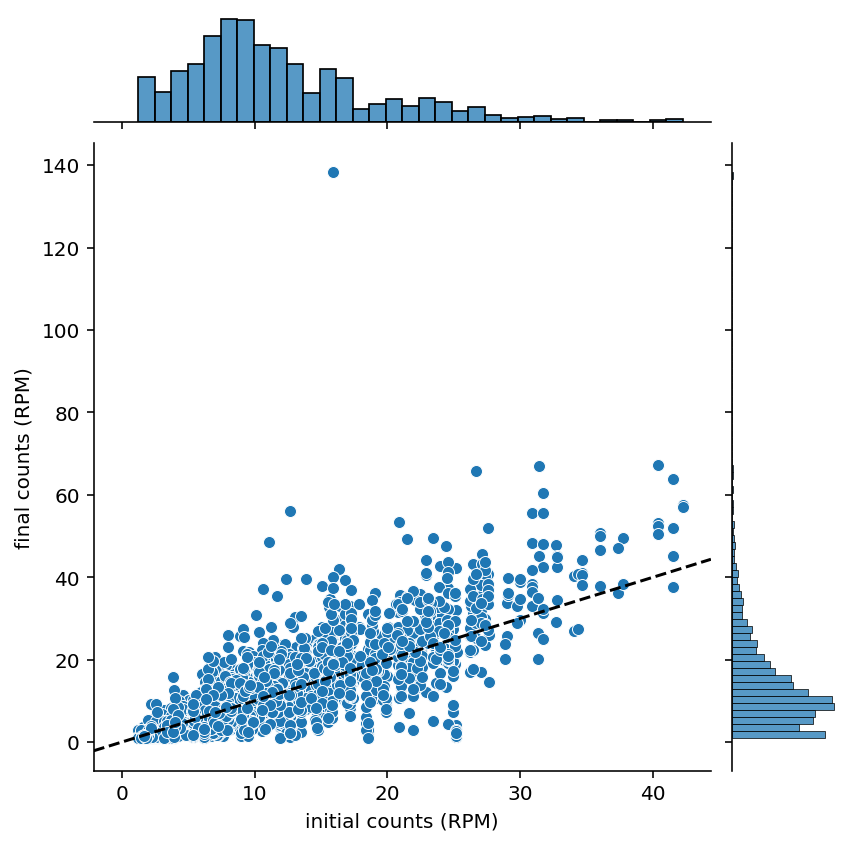

In [12]:
jp = sns.jointplot(data=data, x="counts_initial", y="counts_final_rpm", kind="scatter")
jp.ax_joint.axline((0, 0), slope=1, color="k", ls="--")
jp.ax_joint.set_xlabel("initial counts (RPM)")
jp.ax_joint.set_ylabel("final counts (RPM)");

In [13]:
data[data.counts_final_rpm > 120]

,depmap_id,screen,replicate_id,p_dna_batch,hugo_symbol,sgrna,lfc,counts_final,counts_initial,rna_expr,counts_final_total,counts_initial_total,counts_final_rpm,counts_final_total_adj
309,ACH-000007,sanger,LS513_c903R1,ERS717283.plasmid,TP53,CATTGTTCAATATCGTCCG,3.011199,9256.0,15.930115,6.280028,67379131,1090709.0,138.371911,984.091376


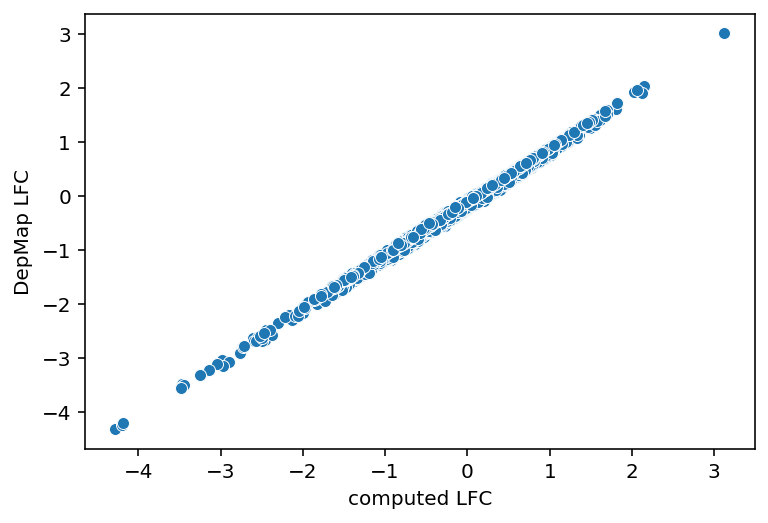

In [14]:
my_lfc = np.log2(data.counts_final_rpm / data.counts_initial)
ax = sns.scatterplot(x=my_lfc, y=data.lfc)
ax.set_xlabel("computed LFC")
ax.set_ylabel("DepMap LFC");

## Modeling

The goal of this notebook is to try different ways of incorporating the "exposure" for each measurement.
In this case, the values of interest are the total number of reads per screen replicate (`replicate_id`) and the composition of the guide in the primary DNA batch (`p_dna_batch`).

The first method is to incorporate the initial read count as a covariate in the model and set the exposure as the total number of reads in the replicate:

$$
\begin{aligned}
\eta &= x_\text{initial RPM} \beta + \dots \\
\mu &= exp(\eta) \\
y &= \text{NB}(\mu \times u_\text{total reads}, \alpha)
\end{aligned}
$$

Another option is to set the exposure as the total number of reads scaled by the fraction of the pDNA library of the guide:

$$
\begin{aligned}
\eta &= x_\text{initial RPM} \beta + \dots \\
\mu &= exp(\eta) \\
y &= \text{NB}(\mu \times u_{\text{%pDNA} \times \text{total reads}}, \alpha)
\end{aligned}
$$

### Model 1.

$$
\begin{aligned}
\mu_{\beta_\text{initial}} &\sim \text{N}(0, 5) \\
\sigma_{\beta_\text{initial}} &\sim \text{HN}(5) \\
\beta_\text{initial} &\sim_{g} \text{N}(\mu_{\beta_\text{initial}}, \sigma_{\beta_\text{initial}}) \\
\eta &= x_\text{initial RPM} \beta_\text{initial}[g] \\
\mu &= \exp(\eta) \\
\alpha &\sim \text{HN}(5) \\
y &\sim \text{NB}(u \times \mu, \alpha)
\end{aligned}
$$

In [15]:
gene_idx, n_genes = dphelp.get_indices_and_count(data, "hugo_symbol")

with pm.Model() as m1:
    g = pm.Data("gene_idx", gene_idx)
    x_initial = pm.Data("x_initial", data.counts_initial.values)
    counts_final_total = pm.Data("counts_final_total", data.counts_final_total.values)
    counts_final = pm.Data("counts_final", data.counts_final.values)

    μ_β = pm.Normal("μ_β", 0, 5)
    σ_β = pm.HalfNormal("σ_β", 5)

    β_init = pm.Normal("β_init", μ_β, σ_β, shape=(n_genes))
    η = x_initial * β_init[g]

    μ = pm.Deterministic("μ", pm.math.exp(η))
    α = pm.HalfNormal("α", 1)
    y = pm.NegativeBinomial("y", counts_final_total * μ, α, observed=counts_final)

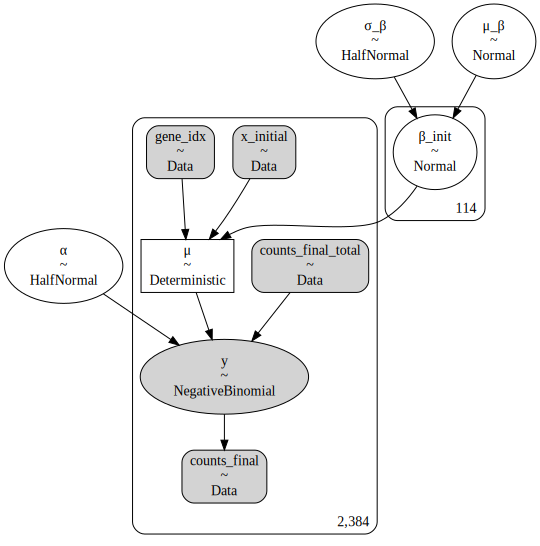

In [16]:
pm.model_to_graphviz(m1)

In [17]:
# with m1:
#     prior_pred = pm.sample_prior_predictive(random_seed=RANDOM_SEED)

In [18]:
with m1:
    m1_trace = pm.sample(
        draws=1000,
        tune=1000,
        cores=2,
        chains=4,
        random_seed=RANDOM_SEED,
        return_inferencedata=True,
    )
    post_pred = pm.sample_posterior_predictive(m1_trace, random_seed=RANDOM_SEED)
    m1_trace.extend(az.from_pymc3(posterior_predictive=post_pred))  # prior=prior_pred,

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [α, β_init, σ_β, μ_β]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 88 seconds.


In [19]:
az.summary(m1_trace, var_names=["μ_β", "σ_β", "α"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ_β,-0.731,0.032,-0.789,-0.670,0.0,0.0,4419.0,2720.0,1.0
σ_β,0.340,0.025,0.296,0.389,0.0,0.0,3802.0,3090.0,1.0
α,0.191,0.004,0.183,0.199,0.0,0.0,3404.0,2774.0,1.0


In [20]:
az.summary(m1_trace, var_names="β_init")[
    ["mcse_mean", "mcse_sd", "ess_bulk", "ess_tail", "r_hat"]
].agg(["mean", np.std, "min", "max"])

,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mean,0.000728,0.000412,4317.921053,2349.087719,1.000175
std,0.000656,0.000577,544.063491,253.636824,0.001319
min,0.000000,0.000000,3104.000000,1643.000000,1.000000
max,0.005000,0.003000,5696.000000,3028.000000,1.010000


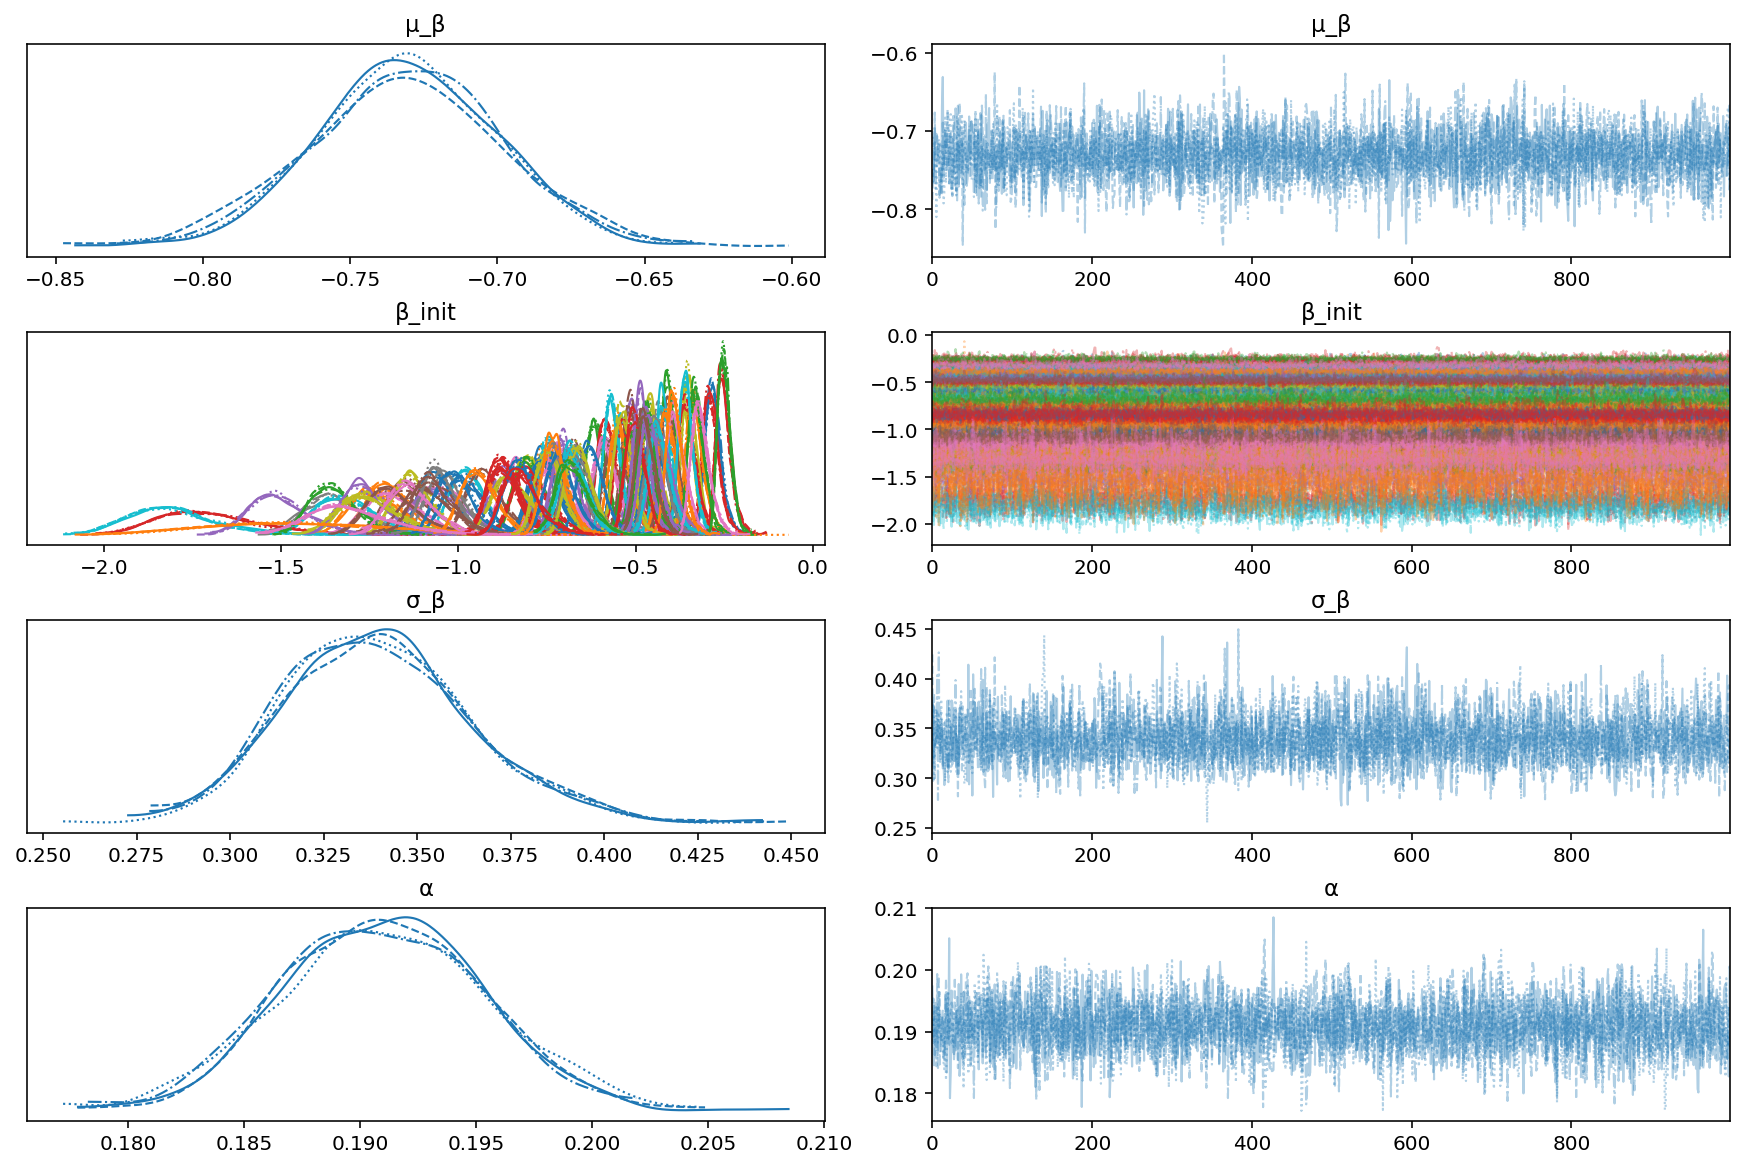

In [21]:
az.plot_trace(m1_trace, var_names=["β", "α"], filter_vars="like");

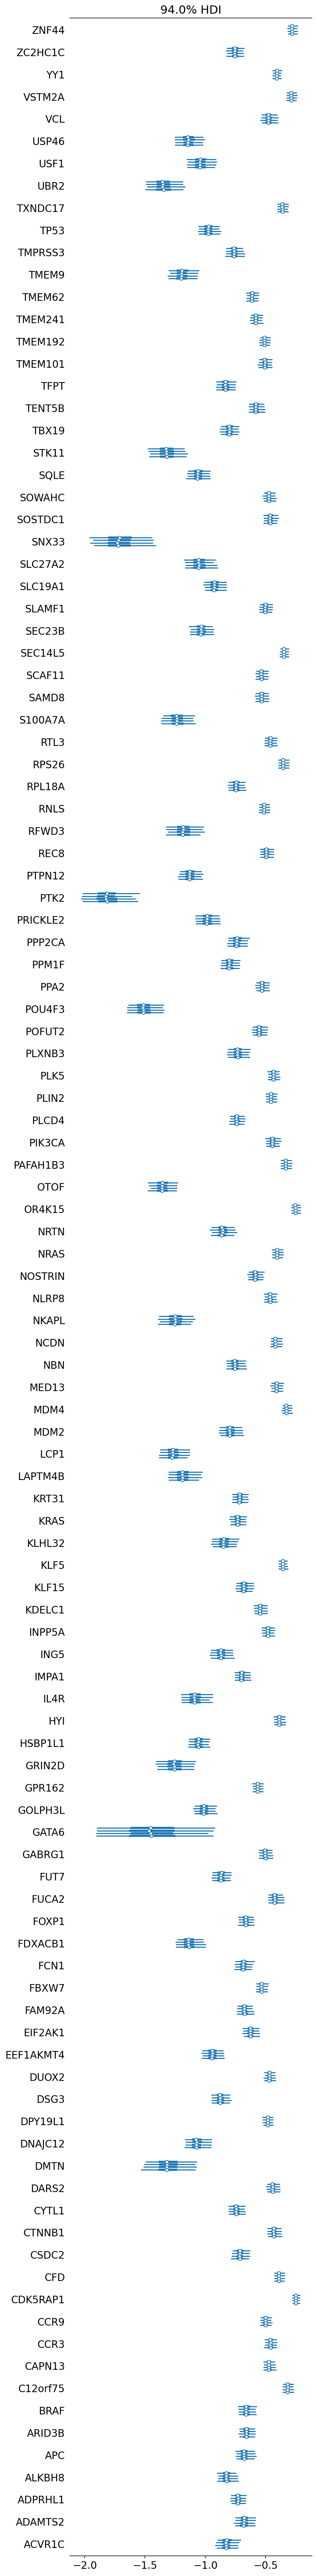

In [22]:
ax = az.plot_forest(m1_trace, var_names="β_init")
ax[0].set_yticklabels(data.hugo_symbol.cat.categories);

In [23]:
data.groupby("hugo_symbol")["lfc"].mean().reset_index(drop=False).query(
    "hugo_symbol == 'BRAF'"
)

,hugo_symbol,lfc
6,BRAF,-0.146036


### Model 2.

$$
\begin{aligned}
\mu_{\beta_\text{initial}} &\sim \text{N}(0, 5) \\
\sigma_{\beta_\text{initial}} &\sim \text{HN}(5) \\
\beta_\text{initial} &\sim_{g} \text{N}(\mu_{\beta_\text{initial}}, \sigma_{\beta_\text{initial}}) \\
\eta &= \beta_\text{initial}[g] \\
\mu &= \exp(\eta) \\
\alpha &\sim \text{HN}(5) \\
y &\sim \text{NB}(u \times \mu, \alpha)
\end{aligned}
$$

In [24]:
gene_idx, n_genes = dphelp.get_indices_and_count(data, "hugo_symbol")

with pm.Model() as m2:
    g = pm.Data("gene_idx", gene_idx)
    counts_final_total_adj = pm.Data(
        "counts_final_total_adj", data.counts_final_total_adj.values
    )
    counts_final = pm.Data("counts_final", data.counts_final.values)

    μ_β_init = pm.Normal("μ_β_init", 0, 2.5)
    σ_β_init = pm.HalfNormal("σ_β_init", 2.5)

    β_init = pm.Normal("β_init", μ_β_init, σ_β_init, shape=(n_genes))
    η = β_init[g]

    μ = pm.Deterministic("μ", pm.math.exp(η))
    α = pm.HalfNormal("α", 5)
    y = pm.NegativeBinomial("y", counts_final_total_adj * μ, α, observed=counts_final)

    # Computed values
    # y_rpm = pm.Constant(1e6) * ((y + 1.0) / data.counts_final_total.values) + pm.Constant(1.0)
    # lfc = pm.Deterministic("lfc", pm.math.log(y_rpm / data.counts_initial.values) / pm.math.log(2.0))

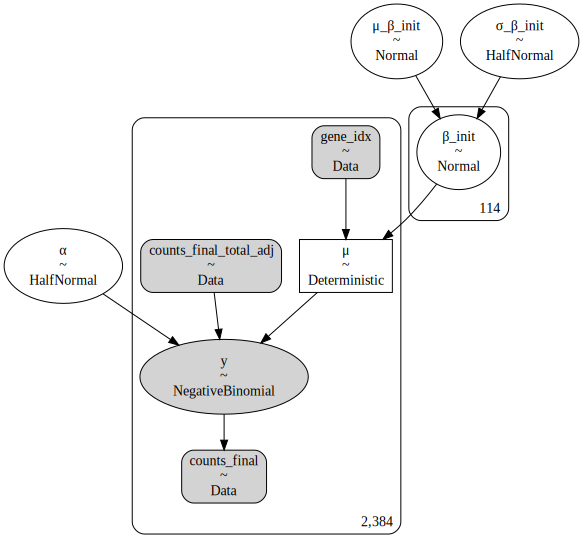

In [25]:
pm.model_to_graphviz(m2)

In [26]:
with m2:
    prior_pred = pm.sample_prior_predictive(random_seed=RANDOM_SEED)

In [27]:
# prior_pred_lfc = (
#     pd.DataFrame(prior_pred["lfc"].squeeze()[:6].T)
#     .pivot_longer()
#     .astype({"variable": str})
# )
# sns.displot(
#     data=prior_pred_lfc,
#     x="value",
#     col="variable",
#     col_wrap=3,
#     kind="hist",
#     kde=True,
#     binwidth=0.1,
# );

In [28]:
with m2:
    m2_trace = pm.sample(
        draws=1000,
        tune=1000,
        cores=2,
        chains=4,
        random_seed=RANDOM_SEED,
        return_inferencedata=True,
    )
    post_pred = pm.sample_posterior_predictive(m2_trace, random_seed=RANDOM_SEED)
    m2_trace.extend(az.from_pymc3(prior=prior_pred, posterior_predictive=post_pred))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [α, β_init, σ_β_init, μ_β_init]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.


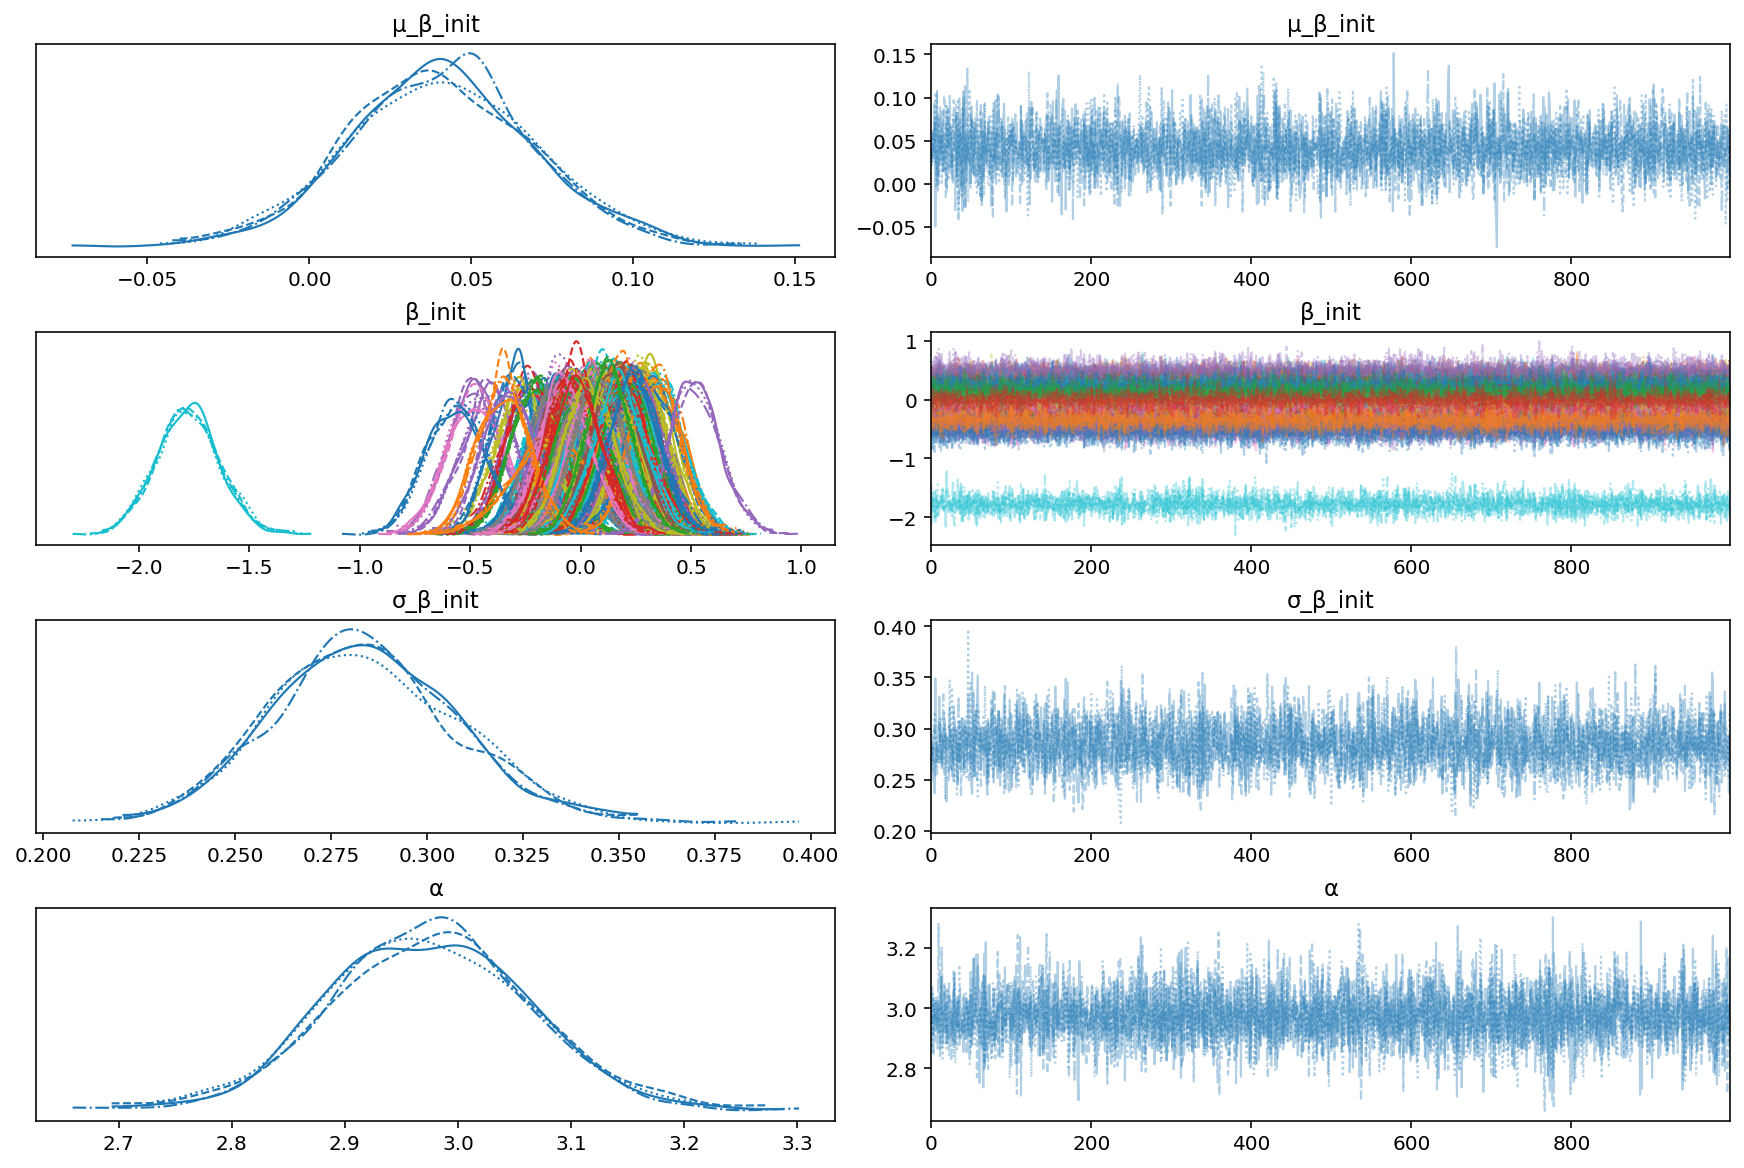

In [29]:
az.plot_trace(m2_trace, var_names=["β", "α"], filter_vars="like");

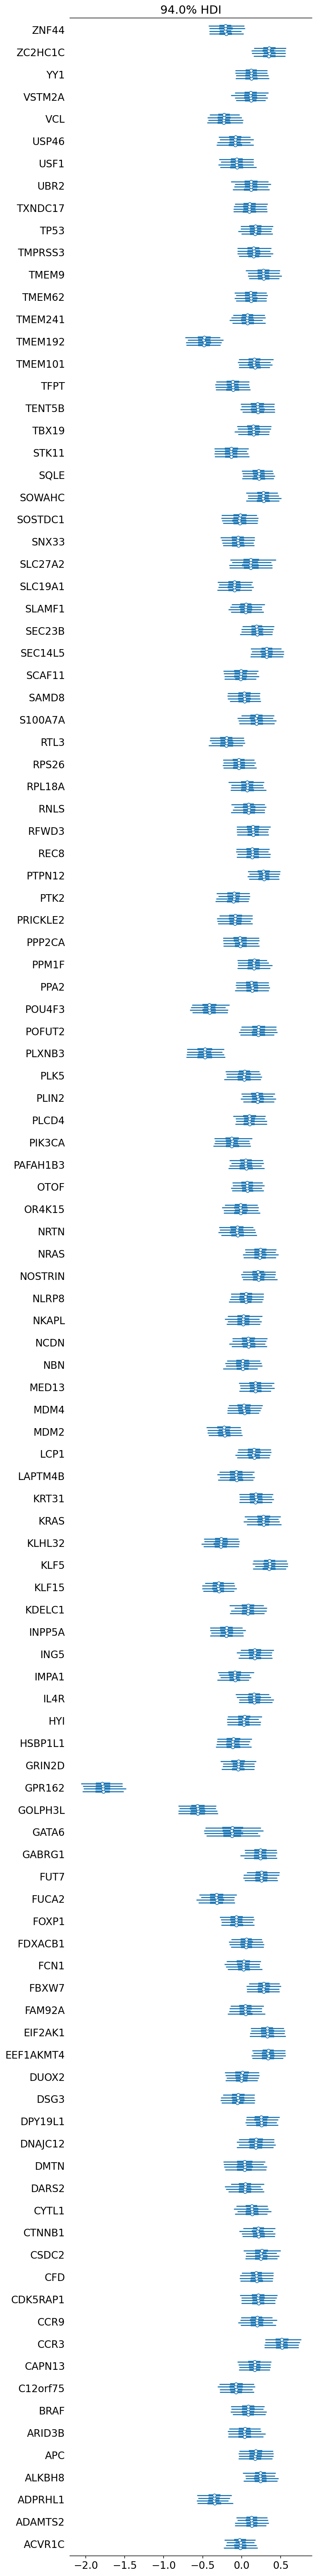

In [30]:
ax = az.plot_forest(m2_trace, var_names="β_init")
ax[0].set_yticklabels(data.hugo_symbol.cat.categories);

---

In [31]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 6.28 minutes


In [32]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2021-10-05

Python implementation: CPython
Python version       : 3.9.6
IPython version      : 7.26.0

Compiler    : Clang 11.1.0 
OS          : Darwin
Release     : 20.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit

Hostname: JHCookMac.local

Git branch: nb-model-2

janitor : 0.21.0
seaborn : 0.11.2
pymc3   : 3.11.2
numpy   : 1.21.2
pandas  : 1.3.2
plotnine: 0.8.0
arviz   : 0.11.2

